### Disciplina: Fundamentos da Computação Gráfica
### Professor: Marcelo Gattass

---------

### Trabalho 1

### Aluna: Fernanda Duarte

-----------------------

### Importando os pacotes

In [1]:
import PIL
from PIL import Image
from itertools import chain
import numpy as np
from numpy import linalg as LA
import os, os.path
import matplotlib.pyplot as plt
from matplotlib import image
from os import walk
import matplotlib.image as mpimg
from skimage import color
from skimage import segmentation
from skimage import io
import skimage
import time
from IPython.display import Image
import time
import colorsys
import random

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\fernandaduarte\Documents\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Abrindo a imagem

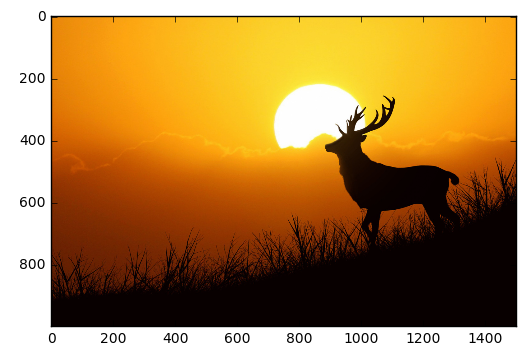

In [2]:
path = 'C:\\Users\\fernandaduarte\\Documents\\Mestrado\\FCG\\T1\\'
#path = 'C:\\Users\\Fernanda\\Anaconda2\\Mestrado CG\\FCG\\T1\\'
i = 'nature1.jpg'
im = io.imread(path+i)
plt.imshow(im)

------

### Função para calcular a medida de distância

In [3]:
def compute_D(c, p, s, m): # [array, tuple], [array, tuple], int, int
    dcolor = LA.norm(np.subtract(c[0], p[0]))
    dspatial = LA.norm(np.subtract(np.array(c[1]), np.array(p[1])))
    return math.sqrt((dcolor**2.) + (((dspatial/s)**2)*(m**2)))

### Função para desenhar os contornos dos superpixels

In [4]:
def draw_edges(labs):
    l = labs.shape[0]
    c = labs.shape[1]
    out = np.full((l,c), 0)
    aux1 = [(i - int(3/2.)) for i in range(int(3))]
    aux2 = [(x, y) for x in aux1 for y in aux1]
    for i in xrange(l):
        for j in xrange(c):
            if (i-1 >= 0) & (i+1 < l) & (j-1 >= 0) & (j+1 < c):
                for p in aux2:
                    if labs[i][j] != labs[i+p[0]][j+p[1]]:
                        out[i][j] = 1
                        break
    return out

### Função que calcula o gradiente

In [5]:
def ComputeGradient(im, x, y, h, w):
    if (x-1 >= 0) & (x+1 < w) & (y-1 >= 0) & (y+1 < h):
        return (LA.norm(np.subtract(im[y, x+1, :], im[y, x-1, :])))**2 + (LA.norm(np.subtract(im[y+1, x], im[y-1, x])))**2
    else:
        return inf

### Algoritmo SLIC

In [6]:
def SLIC(k, m, img, e):
    
    start_time = time.time()

    #Convertendo para coordenadas CIELab
    img = skimage.color.rgb2lab(img)

    #Gravando largura(w) e altura(h) da imagem
    h = img.shape[0] # de linhas
    w = img.shape[1] # de colunas

    #Construindo o grid regular
    ##Definindo o tamanho de cada cédula quadrada do grid
    s = round(math.sqrt((w*h)/float(k)))
    h_blocks = int(h/s)
    h_error = h%s
    w_blocks = int(w/s)
    w_error = w%s
    k = int(h_blocks*w_blocks)
    print("A imagem foi dividida em " + str(k) + " clusters! \n")
    
    h_inc = int(h_error/h_blocks)
    h_inc_rest = round(h_error%h_blocks)
    w_inc = int(w_error/w_blocks)
    w_inc_rest = round(w_error%w_blocks)

    sh = s + h_inc
    sw = s + w_inc

    Ck_old = []
    Ck_new = []

    for i in xrange(h_blocks):
        if (i == h_blocks - 1):
            ch = round(i*sh + (sh + h_inc_rest)/2)
        else:
            ch = round(i*sh + sh/2)
        for j in xrange(w_blocks):
            if (j == w_blocks - 1):
                cw = round(j*sw + (sw + w_inc_rest)/2)
            else:
                cw = round(j*sw + sw/2)
            try:
                Ck_new.append([img[ch,cw,:], (cw, ch)])
            except:
                print([ch,cw])

    #Criando a matriz de labels
    Labels =  np.full((h, w), -1)
    
    #Criando a matriz de distâncias
    Dist = np.full((h, w), inf)
    
    #Vetor com erros residuais
    E_lab = [inf for _ in xrange(k)]
    E_xy = [inf for _ in xrange(k)]
    E = inf
    
    #Modificando o centro para o pixel na vizinhançca 3x3 de menor gradiente
    n = [(i - int(3/2)) for i in range(int(3))]
    neigs = [(x, y) for x in n for y in n]
    index = 0
    for c in Ck_new:
        g_min = ComputeGradient(img, c[1][0], c[1][1], h, w)
        for i in neigs:
            try:
                x_i = c[1][0] + i[0]
                y_i = c[1][1] + i[1]
                g_i = ComputeGradient(img, x_i, y_i, h, w)
                if g_i < g_min:
                    Ck_new[index] = [img[y_i,x_i,:], (x_i, y_i)]
                    g_min = g_i
            except:
                continue
        index += 1
    
    #Vetor auxiliar para percorrer a regiao 2s
    s_ = [(i - int(s)) for i in range(int(2*max(sh, sw) + 1))]
    s2 = [(x, y) for x in s_ for y in s_]
    
    it = 0
    it2 = 0
    #SLIC
    while (E > e) & (it < 10):
        it += 1
        print(it)
        Ck_old = Ck_new[:]
        label = 0
        for c in Ck_old:
            for p in s2:
                #if ((c[3] + p[0]) >= 0) & ((c[3] + p[0]) <= (w - 1)) & ((c[4] + p[1]) >= 0) & ((c[4] + p[1]) <= (h - 1)):
                try:
                    x = round(c[1][0] + p[0])
                    y = round(c[1][1] + p[1])
                    pixel = [img[y,x,:], (x, y)]
                    D = compute_D(c, pixel, s, m)
                    if D < Dist[y,x]:
                        Dist[y,x] = D
                        Labels[y,x] = label
                except:
                    continue
            label += 1
        for i in xrange(k):
            pos = np.where(Labels == i)
            Lmean = img[:,:,0][pos[0], pos[1]].mean()
            Amean = img[:,:,1][pos[0], pos[1]].mean()
            Bmean = img[:,:,2][pos[0], pos[1]].mean()
            Xmean = pos[1].mean()
            Ymean = pos[0].mean()
            Ck_new[i] = [np.array([Lmean, Amean, Bmean]), (Xmean, Ymean)]
            E_lab[i] = LA.norm(np.subtract(Ck_new[i][0], Ck_old[i][0]))
            E_xy[i] = LA.norm(np.subtract(np.array(Ck_new[i][1]), np.array(Ck_old[i][1])))
        E = LA.norm(E_lab + E_xy) #concatena listas e calcula a norma
    print("--- %s seconds ---" % (time.time() - start_time))
    return Labels

In [7]:
out1 = SLIC(100, 20., im, 2.)

A imagem foi dividida em 96 clusters! 

1


C:\Users\fernandaduarte\Documents\Anaconda2\lib\site-packages\ipykernel\__main__.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\fernandaduarte\Documents\Anaconda2\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full((1000L, 1500L), -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Users\fernandaduarte\Documents\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
C:\Users\fernandaduarte\Documents\Anaconda2\lib\site-packages\ipykernel\__main__.py:71: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\fernandaduarte\Documents\Anaconda2\lib\site-packages\ipykernel\__main__.py:95: VisibleDeprecationWarning: 

2
3
4
5
6
7
--- 801.40899992 seconds ---


## Pós-processamento

In [8]:
def BFS(labsArr, aux, x, y, nlabel, count):
    
    
    h = labsArr.shape[0] # de linhas
    w = labsArr.shape[1] # de colunas
    
    aux[y, x] = nlabel
    count += 1
    xInc = [0, 1, 0, -1]
    yInc = [1, 0, -1, 0]
    fila = [(x,y)]
    neigs = []
    
    while fila != []:
        pix = fila[0]
        x = pix[0]
        y = pix[1]
        for i in xrange(len(xInc)):
            nx = x + xInc[i]
            ny = y + yInc[i]
            if ((nx >= 0 | nx < w) & (ny >= 0 | ny < h)):
                if ((labsArr[ny, nx] == labsArr[y,x]) & (aux[ny, nx] == -1)):
                    aux[ny, nx] = nlabel
                    fila.append((nx, ny))
                    count += 1
        fila.pop(0)
    return aux, count
    

In [9]:
def FindNeigs(k, newArr):
    h = newArr.shape[0] # de linhas
    w = newArr.shape[1] # de colunas
    
    xInc = [0, 1, 0, -1]
    yInc = [1, 0, -1, 0]
    neigs = []
    
    pos = np.where(newArr == k)
    for j in xrange(pos[0].shape[0]):
        px = pos[1][j]
        py = pos[0][j]
        for i in xrange(len(xInc)):
            nx = px + xInc[i]
            ny = py + yInc[i]
            if ((nx >= 0 | nx < w) & (ny >= 0 | ny < h)):
                if (newArr[ny, nx] != newArr[py,px]):
                    neigs.append(newArr[ny, nx])
    return list(set(neigs))

In [10]:
def PostProcessing(labs, kclusters):
    
    start_time = time.time()
    
    h = labs.shape[0] # de linhas
    w = labs.shape[1] # de colunas
    
    arrAux = np.full((h, w), -1)
    
    minSize = round(((w*h)/float(kclusters))/4)
    
    countList = []
    nlabel = 0
    x = 0
    y = 0
    
    while True:
        count = 0
        arrAux, c = BFS(labs, arrAux, x, y, nlabel, count)
        countList.append(c)
        nlabel += 1
        try:
            x = np.where(arrAux == -1)[1][0]
            y = np.where(arrAux == -1)[0][0]
        except:
            break
    
    countList = np.array(countList)
    print(len(countList))
    smallK = np.where(countList < minSize)[0]
    print(len(smallK))
    
    xInc = [0, 1, 0, -1]
    yInc = [1, 0, -1, 0]
    for k in smallK:
        neigs = FindNeigs(k, arrAux)
        maxNeigCount = 0
        maxNeigLabel = 0
        for i in neigs:
            if countList[i] > maxNeigCount:
                maxNeigCount = countList[i]
                maxNeigLabel = i
        pos = np.where(arrAux == k)
        arrAux[pos[0], pos[1]] = maxNeigLabel
        
        
    print("--- %s seconds ---" % (time.time() - start_time))
    
    #print(count)
    return arrAux
    

In [12]:
out2 = PostProcessing(out1, 187)

7240
7144


C:\Users\fernandaduarte\Documents\Anaconda2\lib\site-packages\ipykernel\__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\fernandaduarte\Documents\Anaconda2\lib\site-packages\ipykernel\__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


--- 202.518999815 seconds ---


---------------

## Resultados:

### 1) Resultado sem pós-processamento

C:\Users\fernandaduarte\Documents\Anaconda2\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full((1000L, 1500L), 0) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


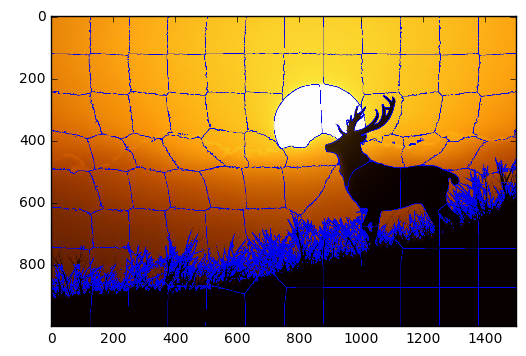

In [16]:
edges = draw_edges(out1)
pos = np.where(edges == 1)

im4 = np.copy(im)
im4[pos[0], pos[1],:] = [0, 0, 240]

plt.imshow(im4)
#skimage.io.imsave('C:\\Users\\fernandaduarte\\Documents\\Mestrado\\FCG\\T1\\teste_200.png', im4)

### 2) Resultado com pós-processamento

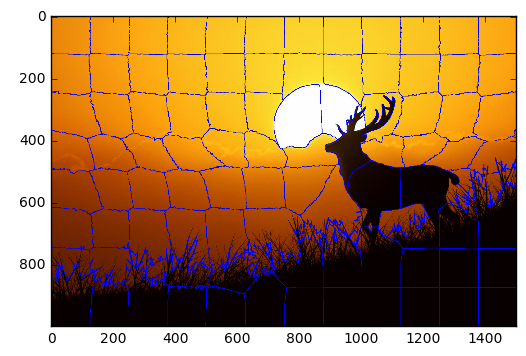

In [17]:
edges = draw_edges(out2)
pos = np.where(edges == 1)

im3 = np.copy(im)
im3[pos[0], pos[1],:] = [0, 0, 255]

plt.imshow(im3)
#skimage.io.imsave('C:\\Users\\fernandaduarte\\Documents\\Mestrado\\FCG\\T1\\teste_200.png', im3)

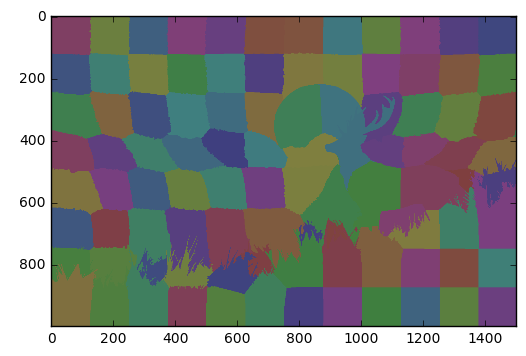

In [15]:
import random

nlabs = np.unique(out2)
N = int(nlabs.shape[0])
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
RGB = [ RGB_tuples[i] for i in random.sample(xrange(len(RGB_tuples)), N) ]

im2 = np.copy(im)
index = 0
for i in nlabs:
    pos = np.where(out2 == i)
    im2[pos[0], pos[1], :] = [int(RGB[index][0]*255), int(RGB[index][1]*255), int(RGB[index][2]*255)]
    index += 1
    
plt.imshow(im2)